In [1]:
import gc
from copy import deepcopy
import numpy as np
import pandas as pd
from random import randint

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from keras import backend as K
from sklearn.model_selection import TimeSeriesSplit

from datetime import datetime
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Add, Subtract
from keras.layers.merge import Concatenate
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
# from keras.applications import VGG16
from keras import initializers
from keras import regularizers
from keras import backend as K

# from libs.pconv_model_UNet import PConvUnet
from keras.models import load_model  

from tqdm import tqdm

matrix_length = 32
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
matrix_df = pd.read_csv('./data/trafficV_M.csv', index_col=0, parse_dates=True)

In [3]:
import math
def l2(y_true, y_pred):
    return math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/1024)

# def createTrainArray(week_history_num=0, minute_history_num=0):
#     week_delta_list = [pd.Timedelta(i+1, unit='W') for i in range(week_history_num)]
#     minute_delta_list = [pd.Timedelta((i+1)*15, unit='m') for i in range(minute_history_num)]
#     # 参考历史数据时间点list
#     delta_list = week_delta_list+minute_delta_list
#     print(delta_list)
    
#     set_up_time = pd.Timedelta(week_history_num, unit='W')
#     # 根据历史数据选取多少，重新构建数据集
#     # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
#     train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
#     train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
#     train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
#     # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
#     train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
#     print(train_array.shape)
#     return train_array


def createTrainArray(week_history_num=0, minute_history_num=0):
    week_delta_list = [pd.Timedelta(week_history_num-i, unit='W') for i in range(week_history_num)]
    minute_delta_list = [pd.Timedelta((minute_history_num-i)*15, unit='m') for i in range(minute_history_num)]
    # 参考历史数据时间点list
    delta_list = minute_delta_list+week_delta_list
    print(delta_list)
    
    set_up_time = pd.Timedelta(week_history_num, unit='W')
    # 根据历史数据选取多少，重新构建数据集
    # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
    train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
    train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
    train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
    # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
    train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
    print(train_array.shape)
    return train_array

In [4]:
week_history_num = 2
minute_history_num = 3

channel_num = week_history_num +minute_history_num +1
smooth_time = channel_num-1

# train_array为(16704, 32, 32, 3)，16704个矩阵，32*32采集点，3从上到下为当前时间，上一周，上一15min
train_array = createTrainArray(week_history_num, minute_history_num)
X_train, X_test = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False)
# X_train, X_val = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False) # 不shuffle可用于查看数据正确性

# X_train = train_array[:16704-900-900]
# X_val = train_array[16704-900-900:16704-900]
# X_test = train_array[16704-900:]

[Timedelta('0 days 00:45:00'), Timedelta('0 days 00:30:00'), Timedelta('0 days 00:15:00'), Timedelta('14 days 00:00:00'), Timedelta('7 days 00:00:00')]
(16032, 32, 32, 6)


In [5]:
# 以第一数据为例. 第一列为待预测数据
# 第一例：1.15 0:00  二：1.8 0:00  三：1.1 0:00  四：1.14 23:45  五：1.14 23:30  六：1.14 23:15
# X_train[0]

In [6]:
matrix_shape = (matrix_length, matrix_length, channel_num)
true_volume_shape = (matrix_length, matrix_length, 1)
history_volume_shape = (matrix_length, matrix_length, channel_num-1)

In [7]:
MAX_BATCH_SIZE = 32
epoch_steps = X_train.shape[0] // MAX_BATCH_SIZE
val_steps = X_test.shape[0] // MAX_BATCH_SIZE
epoch_steps, val_steps

(450, 50)

In [8]:
# 加载数据
def load_data(volume_matrix, batch_size=MAX_BATCH_SIZE):
    n_batches=batch_size
    len_of_matrix = len(volume_matrix)

    batch_i = 0
    while ((batch_i+1)*batch_size < len_of_matrix):
        batch_matrix = volume_matrix[batch_i*batch_size: (batch_i+1)*batch_size]
        true_volume, history_volume = batch_matrix[:, :, :, :1], batch_matrix[:, :, :, 1:]
        batch_i+=1

        yield true_volume, history_volume


In [9]:
import math

def l2(y_true, y_pred):
    return math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/1024)

def l1(y_true, y_pred):
    return np.sum(np.mean(np.abs(y_true - y_pred), axis=0))/(matrix_length*matrix_length)

def mape(y_true, y_pred):
    return np.sum(np.mean((np.abs(y_true - y_pred)/y_true)*100, axis=0))/(matrix_length*matrix_length)

In [10]:
kernel_init = 'glorot_uniform'
bias_init = 'zeros'

# kernel_init = initializers.he_uniform()
# bias_init = initializers.he_uniform()
kernel_regul = regularizers.l2(1)
activity_regul = regularizers.l2(1)

learn_rate = 0.0002

# ResNet block
def identity_block(X, filters, f):

    F1, F2 = filters

    X_shortcut = X

    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(X)

    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# ENCODER
def encoder_layer(img_in, filters, kernel_size, bn=True, resid=True):
    # conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(img_in)
    conv = img_in
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
#             conv = MaxPooling2D((2, 2))(conv)


    if resid:
        conv = identity_block(conv, (filters, filters), kernel_size)

    return conv

# DECODER
def decoder_layer(img_in, e_conv, filters, kernel_size, bn=True, resid=True):
    # up_img = UpSampling2D(size=(2,2))(img_in)
    up_img = img_in
    concat_img = Concatenate(axis=3)([e_conv,up_img])
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same',
                  kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(concat_img)
    if bn:
        conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0)(conv)

    if resid:
        conv = identity_block(conv, (filters, filters), kernel_size)
    return conv



def build_unet():      

    # INPUTS
    history_traffic_volume = Input(shape=history_volume_shape)

    # kernel_init = initializers.he_normal()
    # bias_init = initializers.he_normal()
    kernel_init = 'glorot_uniform'
    bias_init = 'zeros'

#         kernel_init = initializers.he_uniform()
#         bias_init = 'Orthogonal'
    kernel_regul = regularizers.l2(1)
    activity_regul = regularizers.l2(1)

    filters_base = 32
    e_conv1_head = Conv2D(filters=filters_base, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(history_traffic_volume)
#         e_conv1_head = Conv2D(filters=filters_base*1, kernel_size=3, strides=1, padding='same',
#                               kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv1_head)
    e_conv1_tail = AveragePooling2D((2, 2))(e_conv1_head)
    e_conv1 = encoder_layer(e_conv1_tail, filters_base, 3, bn=False)

    e_conv2_head = Conv2D(filters=filters_base*2, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv1)
    e_conv2_tail = AveragePooling2D((2, 2))(e_conv2_head)
    e_conv2 = encoder_layer(e_conv2_tail, filters_base*2, 3)

    e_conv3_head = Conv2D(filters=filters_base*4, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv2)
    e_conv3_tail = AveragePooling2D((2, 2))(e_conv3_head)
    d_conv3_head = encoder_layer(e_conv3_tail, filters_base*4, 3)
    resid1 = Subtract()([e_conv3_tail, d_conv3_head])
    d_conv3_tail = UpSampling2D(size=(2, 2))(resid1)


    d_conv4_head = decoder_layer(d_conv3_tail, e_conv3_head, filters_base*2, 3)
    resid2 = Subtract()([d_conv4_head, e_conv2_tail])
    d_conv4_tail = UpSampling2D(size=(2, 2))(resid2)


    d_conv5_head = decoder_layer(d_conv4_tail, e_conv2_head, filters_base*1, 3)
    resid3 = Subtract()([d_conv5_head, e_conv1_tail])
    d_conv5_tail = UpSampling2D(size=(2, 2))(resid3)

    d_conv6_head = decoder_layer(d_conv5_tail, e_conv1_head, filters_base//2, 3, bn=False)


    outputs = Conv2D(1, 1, activation = 'relu', kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(d_conv6_head)

    # Setup the model inputs / outputs
    model = Model(inputs=history_traffic_volume, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer = Adam(lr=learn_rate),
        loss='mse'
    )

    return model

In [11]:
unet = build_unet()

In [12]:
# unet.summary()

In [13]:
lr_step = []
l2_validation = []

def train(train_matrix, epochs, batch_size=MAX_BATCH_SIZE, learn_rate=0.01):

    start_time = datetime.now()
    min_mse=999
    print("train start "+str(start_time))

    for epoch in range(epochs):
#         if epoch>2 and epoch % 1 == 0 and epoch != 0:
#             if learn_rate>0.0001:
#                 if epoch%3==0:
#                     learn_rate = 0.6*learn_rate
#                 else:
#                     learn_rate = 0.8*learn_rate
#                 K.set_value(unet.optimizer.lr, learn_rate)
                
        for batch_i, (true_volume, history_volume) in enumerate(load_data(train_matrix,batch_size)):
            # true_volume 真实待预测路网交通量  history_volume 路网交通量历史数据
            #  训练 unet
            #  训练 Generator
            g_loss = unet.train_on_batch(history_volume, true_volume)


        elapsed_time = datetime.now() - start_time
        # Plot the progress
        y_pred = unet.predict(X_test[:, :, :, 1:])
        y_true = X_test[:, :, :, :1]

        l2_epoch_validation = l2(y_true, y_pred)
        l1_epoch_validation = l1(y_true, y_pred)
        
        y_pred[y_true==0] += 1
        y_true[y_true==0] += 1
        mape_epoch_validation = mape(y_true, y_pred)
        
        lr_step.append(K.get_value(unet.optimizer.lr))
        l2_validation.append(l2_epoch_validation)
        
        if(l2_epoch_validation<18 and l2_epoch_validation>14 and l2_epoch_validation<min_mse):
            unet.save_weights('./model/RUnet/tmp/runet_forecast.h5')
            min_mse = l2_epoch_validation
            
        l2_validation.append(l2_epoch_validation)
        if epoch%1==0:
#             print("unet lr:"+ str(K.get_value(unet.optimizer.lr)))
            print ("[RUnet %d/%d]  [mse: %f] [mae: %f] [mape: %f] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                    l2_epoch_validation,
                                                                    l1_epoch_validation,
                                                                    mape_epoch_validation,
                                                                    g_loss,
                                                                    elapsed_time))

In [14]:
# train(X_train, epochs=200, batch_size=MAX_BATCH_SIZE, learn_rate=learn_rate)

In [15]:
# unet.save_weights('./model/RUnet/unet_60epoch_18rmse.h5')
unet.load_weights('./model/RUnet/runet_rmse16.61_final/runet_forecast_16.61.h5')

In [16]:
y_pred = unet.predict(X_test[:, :, :, 1:])
y_true = X_test[:, :, :, :1]

mape(y_true, y_pred)

6.097096143539815

In [17]:
# every_rmse = np.sqrt(np.mean(np.square(y_true - y_pred), axis=0))
# every_mae = np.mean(np.abs(y_true - y_pred), axis=0)
# every_mape = np.mean((np.abs(y_true - y_pred)/y_true), axis=0)

# import pickle
# with open('./data/实验结果数据/runet/runet_everyObservationr_rmse.data','wb') as f:
#     pickle.dump(every_rmse,f)
    
# with open('./data/实验结果数据/runet/runet_everyObservationr_mae.data','wb') as f:
#     pickle.dump(every_mae,f)
    
# with open('./data/实验结果数据/runet/runet_everyObservationr_mape.data','wb') as f:
#     pickle.dump(every_mape,f)

In [18]:
matrix = np.mean(y_true-y_pred, axis=0)
np.where(matrix==np.max(matrix))

(array([6], dtype=int64), array([28], dtype=int64), array([0], dtype=int64))

In [19]:
matrix[20][31]=0
np.where(matrix==np.max(matrix))

(array([6], dtype=int64), array([28], dtype=int64), array([0], dtype=int64))

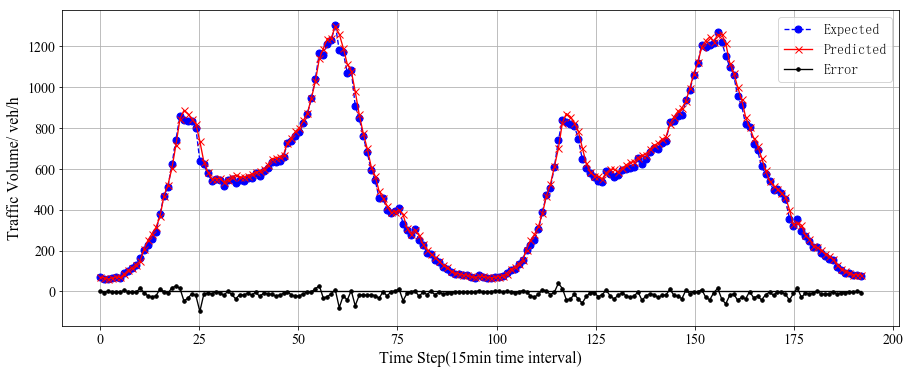

In [24]:
import matplotlib as mpl
# del mpl.font_manager.weight_dict['roman']
# mpl.font_manager._rebuild()

from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")
fontsz = 16

posX = 21
posY = 27
startX = 1230
gapX = 192

zero_line = np.random.randint(0, 1, (gapX,))

y = y_true[:, posX, posY, :][startX: startX+gapX]
yf = y_pred[:, posX, posY, :][startX: startX+gapX]
x = np.linspace(0, len(y), len(y))

fig, ax = plt.subplots(figsize=(15, 5.8))
lines = plt.plot(x, y, x, yf, x,y-yf, x,zero_line)
l1, l2, l3, l4 = lines

plt.setp(lines, markersize=7, linewidth=1.34)
plt.setp(l1, color='b', linestyle='--', marker='o')  # line1 is thick and red
plt.setp(l2, color='r', linestyle='-', marker='x')  # line2 is thinner and green
plt.setp(l3, color='k', linestyle='-', marker='.')  # line2 is thinner and green
plt.setp(l4, color='k', linestyle='-')  # line2 is thinner and green

# plt.ylabel('交通量/ 辆/小时', fontproperties=font, fontsize=fontsz)
# plt.xlabel('观测时间点', fontproperties=font, fontsize=fontsz)
plt.ylabel('Traffic Volume/ veh/h', fontsize=fontsz)
plt.xlabel('Time Step(15min time interval)', fontsize=fontsz)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
y_major_locator=plt.MultipleLocator(200)
ax.yaxis.set_major_locator(y_major_locator)

qwe = range(0,2000,500)
# plt.yticks(qwe, ('0', '500', '1000', '1500'))
# ax.legend(('真实值', '修复值', '误差'), prop=font, fontsize=fontsz-10, loc=1)
ax.legend(('Expected', 'Predicted', 'Error'), prop=font, loc=1)
plt.rcParams.update({'font.size': fontsz-2})
plt.rc('font',family='Times New Roman')
# plt.savefig("./pic/runet两日预测.png", dpi=500)
plt.show()

In [20]:
# import pickle
# with open('./wgan画图matrix偏差值.data','rb') as f:
#     matrix_wgan = pickle.load(f)
    
# matrix_runet = np.mean(y_true[startX: startX+gapX]-y_pred[startX: startX+gapX], axis=0)

In [21]:
matrix_diff = np.abs(matrix_runet)-np.abs(matrix_wgan)

NameError: name 'matrix_runet' is not defined

In [ ]:
matrix_diff[posX][posY]

In [ ]:
matrix_diff[posX][posY]=0
max_may = np.where(matrix_diff==np.max(matrix_diff))

posX = max_may[0][0]
posY = max_may[1][0]

posX, posY

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

start_time = 1600
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 10))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

In [ ]:
yi = l2_validation
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(xi, yi, 'k^--', linewidth=1, markersize=6)
plt.show()

In [ ]:
y = lr_step
x = np.linspace(0, len(y), len(y))
fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(x, y, 'ko-', linewidth=1, markersize=6)

In [ ]:
y_pred

In [ ]:
y_true